In [106]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import json

In [108]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df=df.dropna( subset=["score"])
df["goal diff"] = (df["home_goals"]  - df["away_goals"])
df["results"] = np.where(df["goal diff"] > 0, "1", np.where(df["goal diff"] < 0, "2", "X"))
df.head()

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2


In [109]:
home_team_dummies = pd.get_dummies(df.home_team)
away_team_dummies = pd.get_dummies(df.away_team)


In [110]:
teams = list(home_team_dummies.columns)
team_dict = {}
for i in teams:
    team_dict[i] = "H_"+ i
home_team_dummies = home_team_dummies.rename(columns=team_dict)
home_team_dummies

,H_AD Almería,H_Alavés,H_Albacete,H_Alcorcón,H_Algeciras CF,H_Alicante CF,H_Alzira,H_Arenas Club,H_Arosa SC,H_At. Madrileño,...,H_UD Vecindario,H_UE Figueres,H_UE Lleida,H_UP Langreo,H_Uni. Las Palmas,H_Valencia,H_Villarreal,H_Villarreal CF B,H_Xerez CD,H_Écija Balompié
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
def parse_seasons(value):
    if value == "all":
        return "all"
    seasons = []
    for chunk in value.split(","):
        if ":" in chunk:
            try:
                start, end = map(int, chunk.split(":"))
                assert start < end
            except Exception:
                print("error")
            for i in range(start, end):
                seasons.append(f"{i}-{i+1}")
        else:
            try:
                start, end = map(int, chunk.split("-"))
                assert start == end - 1
            except Exception:
                print("error")
            seasons.append(chunk)
    return seasons

with open("../abs_rankings.json", "r") as ranking_input:
    abs_rankings = json.load(ranking_input)

results_dic = {}

def inv_conv(lst):
    return [ -i for i in lst ]

def direct_confrontations_and_ranking(Team1, Team2, df):
    ranking_team1 = []
    ranking_team2 = []
    df3 = df.loc[((df["home_team"] == Team2) & (df["away_team"] == Team1)) | ((df["home_team"] == Team1) & (df["away_team"] == Team2))]
    df3["Winner"] = np.where(df3["goal diff"] > 0, df3.home_team.values, np.where(df3["goal diff"] < 0, df3.away_team.values, "tie"))
    direct_confrontation_count = df3["Winner"].value_counts()
    if Team1 not in direct_confrontation_count and Team2 not in direct_confrontation_count:
        team1_scoring = 0
        team2_scoring = 0
    elif Team1 not in direct_confrontation_count or Team2 not in direct_confrontation_count:
        if Team1 not in direct_confrontation_count:
            team1_scoring = 0
            team2_scoring = direct_confrontation_count[Team2]
        else:
            team1_scoring = direct_confrontation_count[Team1]
            team2_scoring = 0
    else:
        team1_scoring = direct_confrontation_count[Team1]
        team2_scoring = direct_confrontation_count[Team2]
    
    seasons = df3["season"].unique()
    for season in seasons:
        ranking_team1.append(abs_rankings[season][Team1])
        ranking_team2.append(abs_rankings[season][Team2])
    avg_ranking_team1 = round(np.average(ranking_team1), 3)
    avg_ranking_team2 = round(np.average(ranking_team2), 3)
    return [team1_scoring - team2_scoring, avg_ranking_team1 - avg_ranking_team2]


def dic_saver(team1, team2, df):
    subdic_direct = {}
    subdic_inv = {}
    direct_conf_res = direct_confrontations_and_ranking(team1, team2, df)
    subdic_direct[team2] = direct_conf_res
    subdic_inv[team1] = inv_conv(direct_conf_res)
    results_dic[team1] = subdic_direct
    results_dic[team2] = subdic_inv

In [112]:
df = pd.concat([df, home_team_dummies], axis=1)
df = pd.concat([df, away_team_dummies], axis=1)
columns = list(df.columns)


In [113]:
season_2008 = df[df.season == "2008-2009"]
season_2009 = df[df.season == "2009-2010"]
seasons = parse_seasons("2000:2003")
training_seasons = df[df["season"].isin(seasons)]
test_season = season_2008

In [114]:
training_seasons["win_diff"] = 0
training_seasons["rank_diff"] = 0
for index, row in training_seasons.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    dic_saver(home_team, away_team, training_seasons)
    # results_dic [team1][team2] = [win1-win2, rank1-rank2]
    training_seasons.at[row.name,"win_diff"] = results_dic[home_team][away_team][0]
    training_seasons.at[row.name,"rank_diff"] = results_dic[home_team][away_team][1]

In [115]:
test_season["win_diff"] = 0
test_season["rank_diff"] = 0
for index, row in test_season.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    # results_dic [team1][team2] = [win1-win2, rank1-rank2]
    try:
        test_season.at[row.name,"win_diff"] = results_dic[home_team][away_team][0]
        test_season.at[row.name,"rank_diff"] = results_dic[home_team][away_team][1]
    except:
        test_season.at[row.name,"win_diff"] = 1
        test_season.at[row.name,"rank_diff"] = 1

## All features

In [116]:
x_train = training_seasons.drop(columns=['season',
 'date',
 'matchday',
 'division',
 'day',
 'year',
 'month',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results'])
y_train = training_seasons.results
x_test = test_season.drop(columns=['season',
 'date',
 'matchday',
 'division',
 'day',
 'year',
 'month',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results'])
y_test = list(test_season.results)

## Only Rank and Wins diff

In [120]:
x_train = training_seasons[["win_diff", "rank_diff"]]
y_train = training_seasons["results"]
x_test = test_season[["win_diff", "rank_diff"]]
y_test = test_season["results"]

## Only dummies

In [124]:
x_train = training_seasons.drop(columns=['season',
 'date',
 'matchday',
 'division',
 'day',
 'year',
 'month',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results',
 'rank_diff',
 'win_diff'])
y_train = training_seasons.results
x_test = test_season.drop(columns=['season',
 'date',
 'matchday',
 'division',
 'day',
 'year',
 'month',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results',
 'rank_diff',
 'win_diff'])
y_test = list(test_season.results)

In [136]:
c = [0.01,0.1,0.2,0.5,1,2,5]
accuracies = []
for i in c:
    print(f"TRaining with parameter C={i}")
    model = svm.SVC(C=i)
    model.fit(x_train, y_train)
    accuracies.append(model.score(x_test, y_test))
    

TRaining with parameter C=0.01
TRaining with parameter C=0.1
TRaining with parameter C=0.2
TRaining with parameter C=0.5
TRaining with parameter C=1
TRaining with parameter C=2
TRaining with parameter C=5


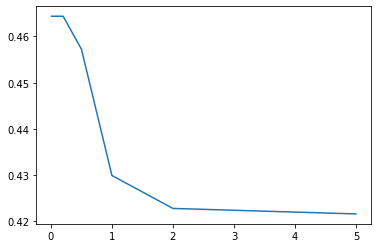

In [139]:
plt.plot(c, accuracies)
plt.show()

In [146]:
accuracies = []
kernels = ["linear", "poly", "rbf", "sigmoid"]
for i in kernels:
    print(f"TRaining with kernel {i}")
    model = svm.SVC(C=2, kernel=i)
    model.fit(x_train, y_train)
    accuracies.append(model.score(x_test, y_test))


TRaining with kernel linear
TRaining with kernel poly
TRaining with kernel rbf
TRaining with kernel sigmoid


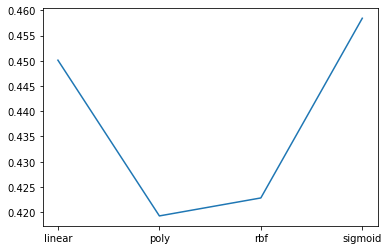

In [147]:
plt.plot(kernels, accuracies)
plt.show()

In [175]:
c = [0.01,0.1,0.5,1,2]
kernels = ["linear", "poly", "rbf", "sigmoid"]

def accuracies_func(c_value, kernel_value):
    #print(f"Training with parameter C={c_value} and kernel {kernel_value}")
    model = svm.SVC(C=c_value, kernel=kernel_value)
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

acc_df = pd.DataFrame()
accuracies = np.empty(shape=(len(c), len(kernels)), dtype=float)
for i in range(len(c)):
    for j in range(len(kernels)):
        accuracies[i][j] = accuracies_func(c[i], kernels[j])
accuracies


array([[0.46437055, 0.46437055, 0.46437055, 0.46437055],
       [0.46437055, 0.46437055, 0.46437055, 0.46437055],
       [0.45249406, 0.44655582, 0.45724466, 0.45605701],
       [0.45011876, 0.41686461, 0.42992874, 0.45130641],
       [0.45011876, 0.4192399 , 0.42280285, 0.4584323 ]])

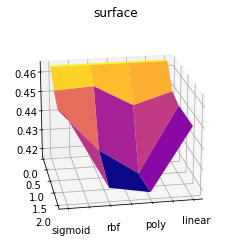

In [212]:
c = [0.01,0.1,0.5,1,2]
kernels = [1,2,3,4]
c, kernels = np.meshgrid(kernels, c)
ax = plt.axes(projection='3d')
ax.plot_surface(c, kernels, accuracies, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
#ax.plot_wireframe(c, kernels, accuracies, color='black')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["","linear", "", "poly", "",  "rbf", "", "sigmoid"]

ax.set_xticklabels(labels)
ax.set_title('surface');
ax.view_init(20, 80)

In [135]:
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.4643705463182898

In [127]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[326,  20,  45],
       [172,  23,  30],
       [203,  10,  13]], dtype=int64)

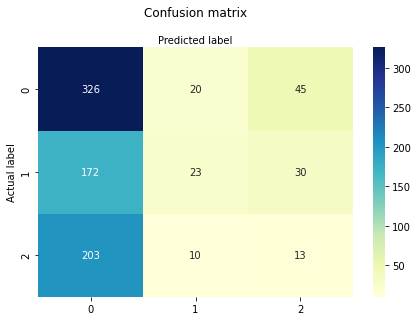

In [213]:
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

In [214]:
coeficients  = pd.DataFrame({"Variable":x_train.columns, "Coefficient":model.coef_[0]})
#coeficients.to_excel('LR_coef.xlsx', sheet_name='LR_coef')

AttributeError: coef_ is only available when using a linear kernel

In [215]:
coeficients = coeficients.sort_values("Coefficient", ascending=False)